# Face Recognition by using MTCNN and FaceNet

### Reference: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

In [1]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from PIL import Image as pilImage
from matplotlib import pyplot
import matplotlib.pyplot as plt
from numpy import savez_compressed
from numpy import asarray
import numpy as np
from mtcnn.mtcnn import MTCNN

In [2]:
#Disable warning message generated from MTCNN library
import logging
import os
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
#global parameters 
mtcnnDetector = MTCNN()

In [4]:
# draw an image with detected objects
def plot_image(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = plt.Circle(value, radius=2, color='red')
            ax.add_patch(dot)
        
    # show the plot
    plt.show()

In [5]:
# draw an image with detected objects
def plot_face(data):
    # plot the image
    plt.imshow(data)
        
    # show the plot
    plt.show()

## Convert face to vector

In [6]:
def extract_face_list(filePath):
    face_size = (160, 160)
    
    img = pilImage.open(filePath).convert('RGB')
    imgArr = np.array(img)
    faceArr = mtcnnDetector.detect_faces(imgArr)
    #initialize two dimension arrays
    #faceArray = [[0 for x in range(1)] for y in range(len(faceList))]
    
    faceList = list()
#     print(f'{filePath} No. of faces detected: {len(faceArr)}')
    
    #show image with rectangle
#     plot_image(filePath, faceArr)
    
    idx = 0
    for face in faceArr:
        x1, y1, width, height = face['box']
        confidence = face['confidence']
        keypoints = face['keypoints']
        
        # prevent negative return x, y value
        x1, y1 = abs(x1), abs(y1)
        
        # get location of x2, y2 for face extraction
        x2, y2 = x1 + width, y1 + height
        
        # extract the face from image array
        targetFace = imgArr[y1:y2, x1:x2]
        
        # resize detected face, convert as array for output
        faceImg = pilImage.fromarray(targetFace)
        faceImg = faceImg.resize(face_size)
        
        #add to list for later return
        faceList.append(np.array(faceImg))
        
        #show extracted face
        #plot_face(faceImg)
        
        idx += 1
#         print(f'face {idx}')
#         print(f'x1 {x1}, y1 {y1}, width {width}, height {height}')
#         print(f'confidence {confidence}')
#         print(f'keypoints {keypoints}')
        
#     print('>loaded %d faces for image: %s' % (len(faceList), filePath))
#     print(f'[{filePath}] No. of faceList extracted: {len(faceList)}')
    
        #print(f"Face shape:{np.asarray(faceList).shape}, value[0]: {faceList[0]}")
    return faceList
    
    
#testing 
#faceList =extract_face_list('real_dataset/avengers.png')
#faceList = extract_face_list('real_dataset/test/test1.jpeg')
#faceList =extract_face_list('real_dataset/leon.png')
#print(f'faceList: {len(faceList)}')


## Convert face and label to vector

In [7]:
def read_folder_image(directory):
    imageExt = (".png",".jpeg",".jpg",".gif")
    faceList = list()
    nameList = list()
    
    counter = 0
    for item in listdir(directory):
        # path
        fullPath = directory + item 
        
        # extract any files that might be in the dir
        if isdir(fullPath):
            #loop through all files in each sub folder
            counter = 0
            for filename in listdir(fullPath):
                if filename.endswith(imageExt):
                    counter += 1
                    
                    # use folder name as person name 
                    personName = item
                    
                    # get face
                    filePath = fullPath +'/'+ filename
                    extractFaceList = extract_face_list(filePath)
                    faceList.extend(extractFaceList)
                    nameList.extend([personName for _ in range(len(extractFaceList))])
            
            print(f'>loaded person: {personName}, total face: {counter}')
        else:
            continue
#             if item.endswith(imageExt):
#                 #file
#                 filePath = fullPath
#                 extractFaceList = extract_face_list(filePath)
#                 faceList.extend(extractFaceList)
    
    return np.array(faceList),np.array(nameList)



In [8]:

# run
faceList, nameList = read_folder_image('dataset/train/')
print(f'Total faceList: {len(faceList)}, nameList: {len(nameList)}')
print(f'Total faceList: {faceList.shape}, nameList: {nameList.shape}')

#verification
verFaceList, verNameList = read_folder_image('dataset/val/')
print(f'Total faceList: {len(verFaceList)}, nameList: {len(verNameList)}')
print(f'Total faceList: {verFaceList.shape}, nameList: {verNameList.shape}')

>loaded person: ben_afflek, total face: 14
>loaded person: madonna, total face: 19
>loaded person: elton_john, total face: 17
>loaded person: mindy_kaling, total face: 22
>loaded person: jerry_seinfeld, total face: 21
Total faceList: 98, nameList: 98
Total faceList: (98, 160, 160, 3), nameList: (98,)
>loaded person: ben_afflek, total face: 5
>loaded person: madonna, total face: 5
>loaded person: elton_john, total face: 5
>loaded person: mindy_kaling, total face: 5
>loaded person: jerry_seinfeld, total face: 5
Total faceList: 28, nameList: 28
Total faceList: (28, 160, 160, 3), nameList: (28,)


## Save face and name vector to file

In [9]:
#save embedded face vector in compressed foramt
savez_compressed('output/face_vector.npz', faceList, nameList, verFaceList, verNameList)


# Get face embedding

In [10]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model


In [11]:
# load the face dataset
# data = load('output/face_vector.npz')
# faceList, nameList, verFaceList, verNameList = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# print('Loaded: ', faceList.shape, nameList.shape, verFaceList.shape, verNameList.shape)



In [12]:
# load the facenet model developed by Hiroki Taniai 
model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [13]:

# get the face embedding for one face
def get_face_embedding(faceArr):
        #print(f'Before standardize shape:{np.asarray(faceArr).shape}, value[0]: {faceArr[0][:2]}')

        # convert face array to float for standardize
        faceArr = faceArr.astype('float32')

        # standardize value
        mean, std = faceArr.mean(), faceArr.std()
        faceArr = (faceArr - mean) / std

        # convert face frmo one-dimension array to two-dimension array
        reshapeFaceArr = expand_dims(faceArr, axis=0)
        #print(f'After standardize shape:{np.asarray(reshapeFaceArr).shape}, value[0]: {reshapeFaceArr[0][0][:2]}')

        # Get embedding result of each face
        embedFace = model.predict(reshapeFaceArr)
        #print(f'Embedding face shape:{np.asarray(embedFace).shape}, value[0]: {embedFace[0][:2]}')
        #print(f'--------------------------')
        return embedFace[0]



In [14]:
# convert each training face into an embedding
embedFaceList = list()
for faceArr in faceList:
    embedFaceList.append(get_face_embedding(faceArr))
    
print(f'Embedding Training Face shape: {np.asarray(embedFaceList).shape}')

# convert each verificatin face into an embedding
verEmbedFaceList = list()
for faceArr in verFaceList:
    verEmbedFaceList.append(get_face_embedding(faceArr))
print(f'Embedding Verification Face shape: {np.asarray(verEmbedFaceList).shape}')


Embedding Training Face shape: (98, 128)
Embedding Verification Face shape: (28, 128)


In [15]:
# save arrays to one file in compressed format
savez_compressed('output/face_embeddings.npz', embedFaceList, nameList, verEmbedFaceList, verNameList)

# Face Classification


In [16]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


In [17]:
# load verification faces vector list
# data = load('output/face_vector.npz')
# verFaceList = data['arr_2']

# # load all faces embeddings and labels
# data = load('output/face_embeddings.npz')
# embedFaceList, nameList, verEmbedFaceList, verNameList = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']


In [18]:
# normalize faces embedding for better comparsion
# print(f'Before normalization shape:{np.asarray(embedFaceList).shape}, value[0]: {embedFaceList[0][:2]}')
norm = Normalizer(norm='l2') #L2 = least squares
embedFaceList = norm.transform(embedFaceList)
# print(f'After normalization shape:{np.asarray(embedFaceList).shape}, value[0]: {embedFaceList[0][:2]}')

# normalize verification faces 
verEmbedFaceList = norm.transform(verEmbedFaceList)

In [19]:
# encode string label into integer
# print(f'Before string encode for label, shape:{np.asarray(nameList).shape}, value[0]: {nameList[0]}')
labelEncoder = LabelEncoder()
#fit all name into model, total N labels, return N length array
labelEncoder.fit(nameList)
nameListInt = labelEncoder.transform(nameList)
verNameListInt = labelEncoder.transform(verNameList)
# print(f'After string encode for label, shape:{np.asarray(nameList).shape}, value[0]: {nameList[0]}')


## Create decision boundary for training images

In [20]:
# fit Linear Support Vector Machine (SVM)，with decision boundary
model = SVC(kernel='linear', probability=True)
model.fit(embedFaceList, nameListInt)

SVC(kernel='linear', probability=True)

# Random testing

In [21]:
# test model on a random example from the test dataset
randomIdx = np.random.randint(verEmbedFaceList.shape[0])
randomFaceArr = verFaceList[randomIdx]
randomFaceEmb = verEmbedFaceList[randomIdx]
randomFaceNameInt = verNameListInt[randomIdx]
randomFaceNameStr = labelEncoder.inverse_transform([randomFaceNameInt])


# prediction for the face
currEmbFace = expand_dims(randomFaceEmb, axis=0)
predictClass = model.predict(currEmbFace)
predictProb = model.predict_proba(currEmbFace)

# prepare result for display
predictClassInt = predictClass[0]
predictClassProb = predictProb[0, predictClassInt] * 100 #get probability of predict item
predictClassName = labelEncoder.inverse_transform(predictClass)


print('randomIdx: %s' % randomIdx)
print(f'TargetFaceNameStr: {randomFaceNameStr}, TargetFaceNameInt: {randomFaceNameInt}')

print('predictClass: %s' % predictClassInt)
print('predictProb: %s' % predictProb)
print('predictProb[0, predictClassIdx]: %s' % predictClassProb)
print('predictClassName: %s' % predictClassName)


randomIdx: 21
TargetFaceNameStr: ['jerry_seinfeld'], TargetFaceNameInt: 2
predictClass: 2
predictProb: [[0.01563463 0.04535099 0.90332972 0.01610313 0.01958152]]
predictProb[0, predictClassIdx]: 90.33297214464375
predictClassName: ['jerry_seinfeld']


In [22]:

# guess result
if(randomFaceNameInt==predictClassInt):
    print('Bingo!')
else:
    print('WRONG!!!!!')
        
print('Predicted: %s (%.3f)' % (predictClassName, predictClassProb))
print('Expected: %s' % randomFaceNameStr)


Bingo!
Predicted: ['jerry_seinfeld'] (90.333)
Expected: ['jerry_seinfeld']


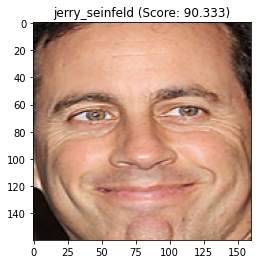

In [23]:
# plot image for eyeball verify
pyplot.imshow(randomFaceArr)
title = '%s (Score: %.3f)' % (predictClassName[0], predictClassProb)
pyplot.title(title)
pyplot.show()